<a href="https://colab.research.google.com/github/astroChance/MPnet/blob/master/MPnet_workbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Directory Definitions


In [1]:
!pip install --upgrade segyio

     |████████████████████████████████| 92kB 3.5MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import segyio
import time
import itertools
import os
import re
import random
from scipy import spatial, signal
import json
from sklearn.preprocessing import normalize, StandardScaler


In [5]:
### Data filenames

# 3D

Volume3D = "/content/drive/My Drive/MPnet/GAN data/3D/PB3D_Fritz_subset.sgy"

# 2D

TwoDFiles = []
for root, dirs, files in os.walk("/content/drive/My Drive/MPnet/GAN data/2D"):
    for name in files:
        filename = os.path.join(root, name)
        TwoDFiles.append(filename)
print("2D files in directory: ", len(TwoDFiles))

2D files in directory:  139


# Custom Functions

In [6]:
## sinc interpolation function

def sinc_interp(x, k):
    # x = signal
    # k = resample factor
    
    mn = x.shape
    if len(mn) == 2:
        m = mn[0]
        n = mn[1]
    elif len(mn) == 1:
        m = 1
        n = mn[0]
    else:
        raise ValueError ("x is greater than 2D")

    nn = n * k
    xt = np.linspace (1, n, n)
    xp = np.linspace (1, n, nn)
    
    nn = len(xp)

    y = np.zeros((m, nn))

    for (pi, p) in enumerate (xp):
        si = np.tile(np.sinc (xt - p), (m, 1))
        y[:, pi] = np.sum(si * x)
        
    return y.squeeze()

# Initial QC

Example 2D line data shape:  (202, 3600)


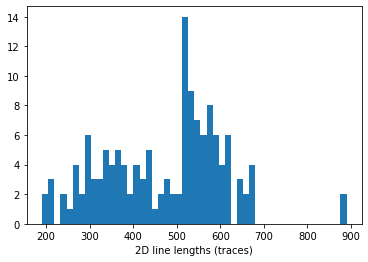


3D data shape:  (501, 501, 1070)


In [ ]:
### Check geometry and line lengths of 2D files

radar_file = random.choice(TwoDFiles)
with segyio.open(radar_file, 'r') as line:
  Line = segyio.tools.collect(line.trace[:])
  print("Example 2D line data shape: ", Line.shape)

Zero_Ax = []

for radar_line in TwoDFiles:
  with segyio.open(radar_line, 'r') as line:
    Line = segyio.tools.collect(line.trace[:])
    Zero_Ax.append(Line.shape[0])

plt.hist(Zero_Ax, bins=50)
plt.xlabel("2D line lengths (traces)")
plt.show()




### Print geometry information for 3D cube

with segyio.open(Volume3D, 'r') as segyfile:
  cube = segyio.tools.cube(segyfile)   
  print("\n3D data shape: ", cube.shape)


In [ ]:
### Visual QC

# radar_file = TwoDFiles[0]
radar_file = random.choice(TwoDFiles)

with segyio.open(radar_file, 'r') as segyfile:
  display_line = segyio.tools.collect(segyfile.trace[:])

plt.figure(figsize=(15,5))
plt.title("2D random line")
plt.imshow(display_line.T, cmap='bone', vmin = -60, vmax = -20, aspect='auto')
plt.colorbar()

with segyio.open(Volume3D, 'r') as segyfile:
  random_iline_num = random.randint(0, len(segyfile.ilines))
  random_iline = segyfile.iline[segyfile.ilines[random_iline_num]]

plt.figure(figsize=(15,5))
plt.title("3D random inline")
plt.imshow(random_iline.T, cmap='bone', aspect='auto', vmin = 0, vmax = 13)
plt.colorbar()


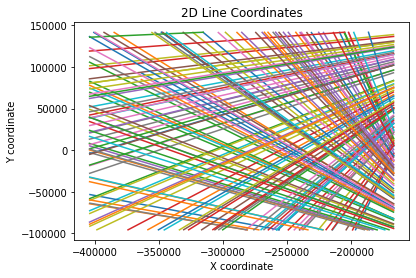

In [ ]:
### Check trace locations from 2D data

line_coords = {}
line_counter = 0
for radar_line in TwoDFiles:
  with segyio.open(radar_line, 'r', ignore_geometry=True) as line:
    x_vals=[]
    y_vals=[]
    for i in range(len(line.trace)):
      x_vals.append(line.header[i][segyio.TraceField.GroupX])
      y_vals.append(line.header[i][segyio.TraceField.GroupY])
    line_coords[line_counter] = {}
    line_coords[line_counter]['x_vals'] = x_vals
    line_coords[line_counter]['y_vals'] = y_vals
    line_counter += 1


for i in range(len(line_coords)):
  plt.plot(line_coords[i]['x_vals'], line_coords[i]['y_vals'])
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.title("2D Line Coordinates")
plt.show()

In [ ]:
with segyio.open(Volume3D, 'r') as line:
  print(line.header[10])

{TRACE_SEQUENCE_LINE: 11, TRACE_SEQUENCE_FILE: 0, FieldRecord: 0, TraceNumber: 0, EnergySourcePoint: 0, CDP: 0, CDP_TRACE: 0, TraceIdentificationCode: 0, NSummedTraces: 0, NStackedTraces: 0, DataUse: 0, offset: 0, ReceiverGroupElevation: 0, SourceSurfaceElevation: 0, SourceDepth: 0, ReceiverDatumElevation: 0, SourceDatumElevation: 0, SourceWaterDepth: 0, GroupWaterDepth: 0, ElevationScalar: 0, SourceGroupScalar: 0, SourceX: 0, SourceY: 0, GroupX: -404475, GroupY: -90975, CoordinateUnits: 0, WeatheringVelocity: 0, SubWeatheringVelocity: 0, SourceUpholeTime: 0, GroupUpholeTime: 0, SourceStaticCorrection: 0, GroupStaticCorrection: 0, TotalStaticApplied: 0, LagTimeA: 0, LagTimeB: 0, DelayRecordingTime: 0, MuteTimeStart: 0, MuteTimeEND: 0, TRACE_SAMPLE_COUNT: 1070, TRACE_SAMPLE_INTERVAL: 375, GainType: 0, InstrumentGainConstant: 0, InstrumentInitialGain: 0, Correlated: 0, SweepFrequencyStart: 0, SweepFrequencyEnd: 0, SweepLength: 0, SweepType: 0, SweepTraceTaperLengthStart: 0, SweepTraceTap

# Create 2D - 3D Trace Match Dictionary

In [ ]:
"""
Design dictionary of:
{2D line number from filename : { 2D trace number : corresponding 3D trace number}

Due to runtime limitations in Colab, write each 2D dict to json file then
concatenate in next cell
"""



# 3D trace coord dictionary, {(Xcoord, Ycoord) : 3D trace number}
# Create array of XY coords for min dist calculation
Trace_coords_3D = {}
coord_3D = np.array([])
counter3D = 0
with segyio.open(Volume3D, 'r') as segyfile:
  for i in range(len(segyfile.trace)):
    Trace_coords_3D[(segyfile.header[i][segyio.TraceField.GroupX], segyfile.header[i][segyio.TraceField.GroupY])] = segyfile.header[i][segyio.TraceField.TRACE_SEQUENCE_LINE]
    tr_coord = np.array([ segyfile.header[i][segyio.TraceField.GroupX], segyfile.header[i][segyio.TraceField.GroupY] ])
    if counter3D == 0:
      coord_3D = np.append(coord_3D, tr_coord)
    else:
      coord_3D = np.vstack((coord_3D, tr_coord))
    counter3D =+ 1

print("3D trace dictionary complete")


# For each 2D line, build dictionary to map 2D trace number
# to closest 3D trace number

TEMP_DICT = {}

line_counter=1
for radar_line in TwoDFiles[52:]:
  with segyio.open(radar_line, 'r') as line:
    line_num = os.path.basename(radar_line).split(".")[0]

    TEMP_DICT = {}
    TEMP_DICT[line_num] = {}

    trace_counter=1
    for i in range(len(line.trace)):
      trace_2D = line.header[i][segyio.TraceField.TRACE_SEQUENCE_LINE]
      
      ## Find 3D nearest neighbor for x and y
      ## minimize (dx + dy)
      coord_2D = np.array([ line.header[i][segyio.TraceField.GroupX], line.header[i][segyio.TraceField.GroupY] ])
      
      closest_3Dtrace = coord_3D[spatial.KDTree(coord_3D).query(coord_2D)[1]]
      closest_3Dtrace = tuple(closest_3Dtrace)

      ## Build the dictionary
     
      TEMP_DICT[line_num][trace_2D] = [Trace_coords_3D[closest_3Dtrace]]
      
      print("\rLine number ", line_counter, "\tTrace number ", trace_counter, "\\",len(line.trace), end="", flush=True)
      trace_counter+=1

    temp_Dict = "/content/drive/My Drive/MPnet/GAN data/tempdicts/" + str(line_num) + ".json"
    with open(temp_Dict, 'w') as dict_file:
      json.dump(TEMP_DICT, dict_file)

    line_counter+=1


print("\nIndividual dictionaries complete")


3D trace dictionary complete
Line number  87 	Trace number  489 \ 489Trace mapping dictionary complete, writing file...


In [ ]:
# Check json file count
# Place all individual dicts into master dict

Trace_Map_Dict = "/content/drive/My Drive/MPnet/GAN data/2D_to_3D_Trace_Dict.json"

Trace_Matcher = {}

indv_dicts = []
for root, dirs, files in os.walk("/content/drive/My Drive/MPnet/GAN data/tempdicts"):
    for name in files:
        filename = os.path.join(root, name)
        indv_dicts.append(filename)
print("2D files in directory: ", len(indv_dicts))

for dic in indv_dicts:
  with open(dic, 'r') as temp_dict:
    tempdict = json.load(temp_dict)
    Trace_Matcher.update(tempdict)


with open(Trace_Map_Dict, 'w') as dict_file:
      json.dump(Trace_Matcher, dict_file)


2D files in directory:  138


In [ ]:
## QC dictionary with random sample

Trace_Map_Dict = "/content/drive/My Drive/MPnet/GAN data/2D_to_3D_Trace_Dict.json"

with open(Trace_Map_Dict, 'r') as TraceDictFile:
  TraceDict = json.load(TraceDictFile)

print(random.choice(list(TraceDict.items())))

('1043102000', {'1': [250558], '2': [250057], '3': [250058], '4': [249558], '5': [249057], '6': [248557], '7': [248557], '8': [248057], '9': [247557], '10': [247056], '11': [247057], '12': [246557], '13': [246056], '14': [245556], '15': [245557], '16': [245056], '17': [244556], '18': [244056], '19': [244056], '20': [243556], '21': [243056], '22': [243056], '23': [242556], '24': [242056], '25': [241555], '26': [241556], '27': [241055], '28': [240555], '29': [240055], '30': [240055], '31': [239555], '32': [239055], '33': [238554], '34': [238555], '35': [238055], '36': [237554], '37': [237555], '38': [237055], '39': [236554], '40': [236054], '41': [236055], '42': [235554], '43': [235054], '44': [234554], '45': [234554], '46': [234054], '47': [233553], '48': [233053], '49': [233054], '50': [232553], '51': [232053], '52': [231553], '53': [231553], '54': [231053], '55': [230553], '56': [230553], '57': [230053], '58': [229553], '59': [229052], '60': [229053], '61': [228553], '62': [228052], '

# QC Trace - Matched Data (with standardized amplitudes), simulate enhanced trace

2D line:  1946701000
2D trace:  66
3D trace:  114776


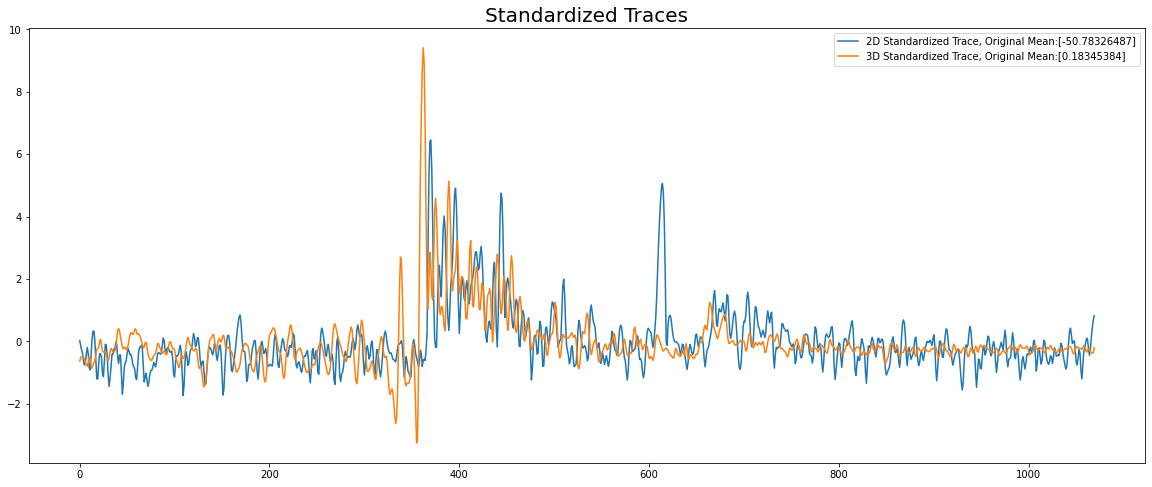

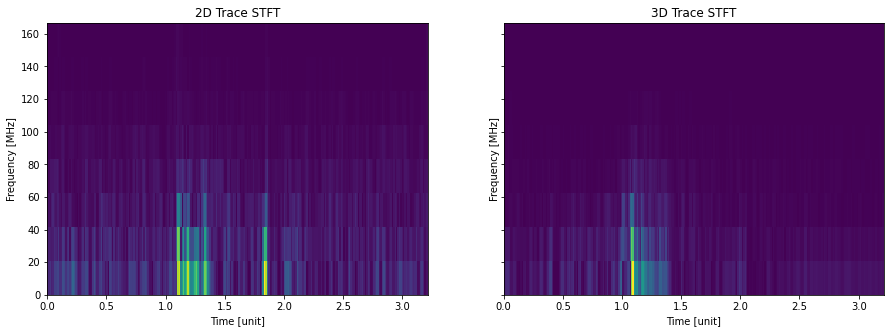



Trace Enhancement Simulation:


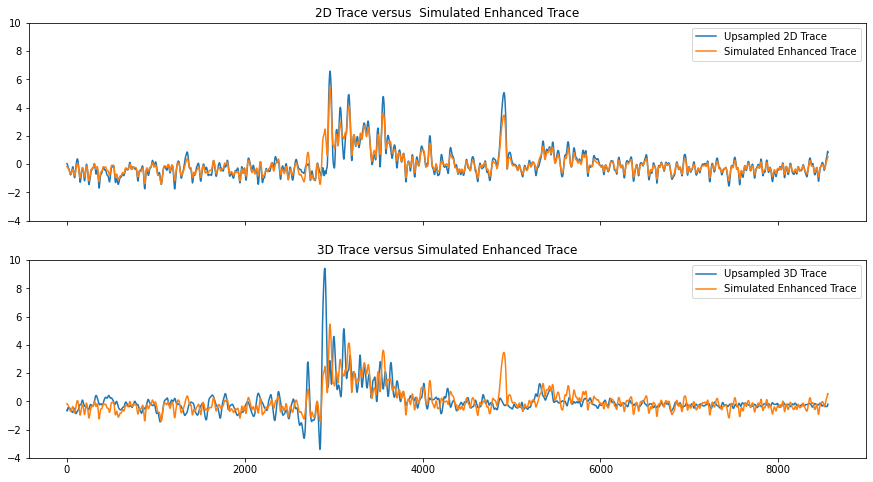

In [10]:
"""
Plot a random 2D trace and it's corresponding 3D trace

Plot spectrograms for each trace

Create simulated 3D enhanced trace (2D blenaded with 3D)
"""
###########################################################
########
# Possible 3D start time: 999.75    end time: 1401     use for slicing 2D trace
# Corresponds roughly to 2D slice [1970:3040]

########
# Set parameters to plot together or separate, standardize curves or not
Plot_Together = 'Y'
Standardize_Trace = 'Y'

########
# Use STFT? If 'N', use basic signal spectrogram w/gouraud shading
Use_STFT = 'Y'

########
# Simulate enhanced trace? (**Only runs with STFT)
# Step 1: Use STFT on 2D and 3D trace
# Step 2: Create blended transform of X% 2D STFT and 1-X% 3D STFT (simulate resolution addition)
# Step 3: Use iSTFT on blended transform

Sim_Trace = 'Y'
blend_amt = (0.7, 0.3)   # (2D, 3D), needs to add to 1

Blend_Parms = 'N'   # create 2 STFT's, blend the results in noise reduction attempt

###########################################################

# Load dictionary to get 2D / 3D trace relationships
Trace_Map_Dict = "/content/drive/My Drive/MPnet/GAN data/2D_to_3D_Trace_Dict.json"
with open(Trace_Map_Dict, 'r') as TraceDictFile:
  TraceDict = json.load(TraceDictFile)

# Randomly choose value from trace match dictionary
Rand2D = random.choice(list(TraceDict.items()))
RandTraceMatch = random.choice(list(Rand2D[1].items()))

Rand2DLine = int(Rand2D[0])
Rand2DTrace = int(RandTraceMatch[0])
Rand3DTrace = int(RandTraceMatch[1][0])

print("2D line: ", Rand2DLine)
print("2D trace: ", Rand2DTrace)
print("3D trace: ", Rand3DTrace)


# Get the random 2D and 3D trace data
Rand2DFile = "/content/drive/My Drive/MPnet/GAN data/2D/" + str(Rand2DLine) + ".sgy"
with segyio.open(Rand2DFile, 'r') as segyfile:
  display_trace_2D = segyfile.trace[Rand2DTrace]
  display_trace_2D = display_trace_2D[1970:3040]

with segyio.open(Volume3D, 'r') as segyfile:
  display_trace_3D = segyfile.trace[Rand3DTrace]


# Create trace plot
if Plot_Together.upper() == 'Y':
  plt.figure(figsize=(20,8))

  if Standardize_Trace.upper() == 'Y':   # Using StandardScaler to adjust relative ampltidues
    scaler2D = StandardScaler()    
    scaler3D = StandardScaler()
    display_trace_2D_expand = display_trace_2D.reshape((len(display_trace_2D), 1))
    display_trace_3D_expand = display_trace_3D.reshape((len(display_trace_3D), 1))
    standardized_2D_trace = scaler2D.fit_transform(display_trace_2D_expand)
    standardized_3D_trace = scaler3D.fit_transform(display_trace_3D_expand)
    plt.plot(standardized_2D_trace, label='2D Standardized Trace, Original Mean:'+str(scaler2D.mean_))
    plt.plot(standardized_3D_trace, label='3D Standardized Trace, Original Mean:'+str(scaler3D.mean_))
    plt.title("Standardized Traces", fontsize=20)
    plt.legend()
    plt.show()

  else:    # Plot together but don't standardized, only adjust 2D absolute values
    adjust_factor = np.mean(display_trace_2D)
    adjusted_2D_trace = display_trace_2D - adjust_factor  
    plt.plot(adjusted_2D_trace, label='2D Adjusted Trace, Original Mean:'+str(adjust_factor))
    plt.plot(display_trace_3D, label='3D Trace, Mean:'+str(np.mean(display_trace_3D)))
    plt.title("Adjusted 2D mean, relative values preserved", fontsize=20)
    plt.legend()
    plt.show()   

else:    # Create two separate subplots
  fig, ax = plt.subplots(2, sharex=True, figsize=(15,8))
  ax[0].plot(display_trace_2D)
  ax[0].set_title('2D Trace')
  ax[1].plot(display_trace_3D)
  ax[1].set_title('3D Trace')
  plt.show()


# Create spectrogram plot
## Spectrogram parameters
fs = 1 / 0.000375     #sample frequency
nperseg = 128        # Potential nperseg/noverlap combos to use: (128, 96), (16,12)
noverlap = 96
window = signal.hann(nperseg, sym=False)

nperseg2 = 16        # Second parameter set used for blended results
noverlap2 = 12
window2 = signal.hann(nperseg2, sym=False)

# Upsampled traces
Upsample_2D = sinc_interp(np.squeeze(standardized_2D_trace), 8)
Upsample_3D = sinc_interp(np.squeeze(standardized_3D_trace), 8)


fig, ax = plt.subplots(1,2, sharey=True, figsize=(15,5))
if Use_STFT.upper() == 'Y':

  f2D, t2D, Zxx2D = signal.stft(Upsample_2D, window = window, fs = fs, nperseg = nperseg, noverlap=noverlap)
  ax[0].pcolormesh(t2D, f2D, np.abs(Zxx2D), shading='flat')
  ax[0].set_ylabel('Frequency [MHz]')
  ax[0].set_xlabel('Time [unit]')
  ax[0].set_title('2D Trace STFT')

  f3D, t3D, Zxx3D = signal.stft(Upsample_3D, window = window, fs = fs, nperseg = nperseg, noverlap=noverlap)
  ax[1].pcolormesh(t3D, f3D, np.abs(Zxx3D), shading='flat')
  ax[1].set_ylabel('Frequency [MHz]')
  ax[1].set_xlabel('Time [unit]')
  ax[1].set_title('3D Trace STFT')

  plt.ylim(0, (max(f2D) / 8))
  plt.show()

  if Sim_Trace.upper() == 'Y':
    print("\n\nTrace Enhancement Simulation:")

    Zxx_blend = blend_amt[0] * Zxx2D + blend_amt[1] * Zxx3D
    _, EnhTrace = signal.istft(Zxx_blend, window = window, fs = fs, nperseg = nperseg, noverlap=noverlap)

    # Compare enhance trace to 2D and 3D traces
    fig, ax = plt.subplots(2, sharex=True, figsize=(15,8))

    ax[0].plot(Upsample_2D, label='Upsampled 2D Trace')
    ax[0].plot(EnhTrace[:len(Upsample_2D)], label='Simulated Enhanced Trace')
    ax[0].legend()
    ax[0].set_title('2D Trace versus  Simulated Enhanced Trace')
    ax[0].set_ylim(-4,10)

    ax[1].plot(Upsample_3D, label='Upsampled 3D Trace')
    ax[1].plot(EnhTrace[:len(Upsample_3D)], label='Simulated Enhanced Trace')
    ax[1].legend()
    ax[1].set_title('3D Trace versus Simulated Enhanced Trace')
    ax[1].set_ylim(-4,10)
    
    plt.show()

    if Blend_Parms.upper() == 'Y':
      print("Blended STFT Results")

      # Create 2D and 3D STFT's with parameter set 2 to use for blending
      f2D_2, t2D_2, Zxx2D_2 = signal.stft(Upsample_2D, window = window2, fs = fs, nperseg = nperseg2, noverlap=noverlap2)
      f3D_2, t3D_2, Zxx3D_2 = signal.stft(Upsample_3D, window = window2, fs = fs, nperseg = nperseg2, noverlap=noverlap2)

      Zxx_blend = blend_amt[0] * Zxx2D_2 + blend_amt[1] * Zxx3D_2
      _, EnhTrace_2 = signal.istft(Zxx_blend, window = window2, fs = fs, nperseg = nperseg2, noverlap=noverlap2)

      # Blend both enhanced traces (mean)
      EnhTrace_blend = np.mean(np.array([EnhTrace[:len(Upsample_2D)], EnhTrace_2[:len(Upsample_2D)]]), axis=0)

      # Calculate differences
      diff1_2D = EnhTrace[:len(Upsample_2D)] - Upsample_2D
      diff1_3D = EnhTrace[:len(Upsample_3D)] - Upsample_3D
      diff_blend_2D = EnhTrace_blend[:len(Upsample_2D)] - Upsample_2D
      diff_blend_3D = EnhTrace_blend[:len(Upsample_3D)] - Upsample_3D

      # Plots
      fig, ax = plt.subplots(2, sharex=True, figsize=(15,5))

      ax[0].plot(diff1_2D, label='Difference to 2D')
      ax[0].plot(diff1_3D, label='Difference to 3D')
      ax[0].legend()
      ax[0].set_title('Difference between Simulated Enhanced Trace and Upsampled 2D / 3D')
      # ax[0].set_ylim(-4,10)

      ax[1].plot(diff_blend_2D, label='Difference to 2D')
      ax[1].plot(diff_blend_3D, label='Difference to 3D')
      ax[1].legend()
      ax[1].set_title('Difference between BLENDED Simulated Enhanced Trace and Upsampled 2D / 3D')
      # ax[1].set_ylim(-4,10)
      
      plt.show()

else:

  f2D, t2D, Sxx2D = signal.spectrogram(Upsample_2D, fs)
  ax[0].pcolormesh(t2D, f2D, Sxx2D, shading='gouraud')
  ax[0].set_ylabel('Frequency [MHz]')
  ax[0].set_xlabel('Time [unit]')
  ax[0].set_title('2D Trace Spectrogram')

  f3D, t3D, Sxx3D = signal.spectrogram(Upsample_3D, fs)
  ax[1].pcolormesh(t3D, f3D, Sxx3D, shading='gouraud')
  ax[1].set_ylabel('Frequency [MHz]')
  ax[1].set_xlabel('Time [unit]')
  ax[1].set_title('3D Trace Spectrogram')

  # plt.ylim(0, (max(f2D) / 8))
  plt.show()

Checking Line Dimensions:
2D:  (437, 1070)
3D:  (437, 1070)


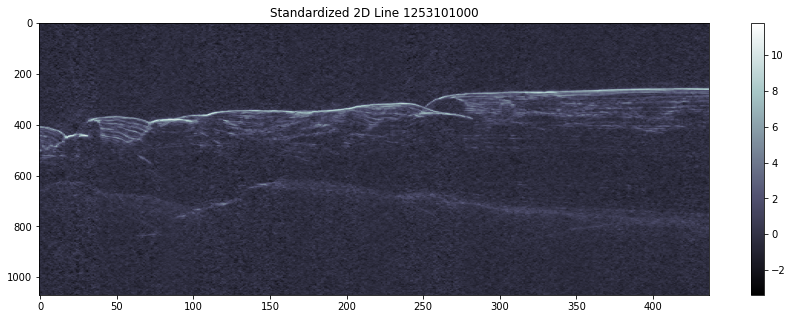

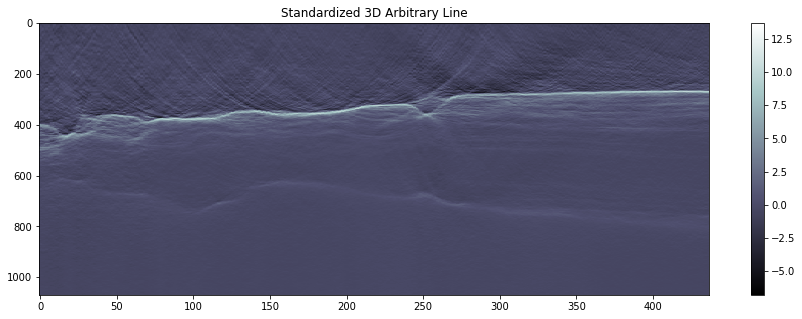

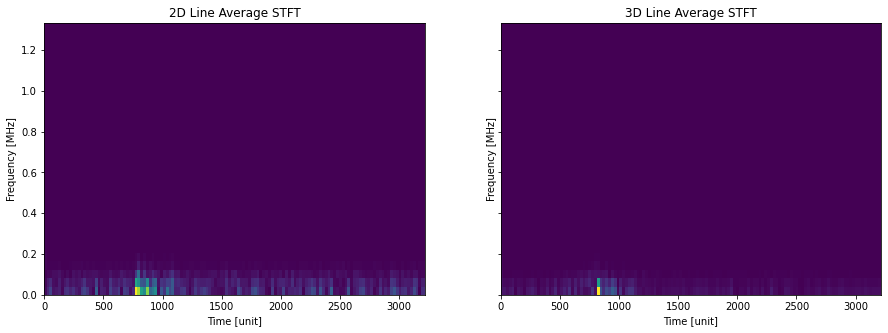

In [ ]:
## Plot 2D line and the corresponding 3D Arb line
## Plot average spectrograms

###########################################################
########
# Possible 3D start time: 999.75    end time: 1401     use for slicing 2D trace
# Corresponds roughly to 2D slice [1970:3040]

########
# Set paramter to standardize amplitude values or not
Standardize_Trace = 'Y'

########
# Use STFT? If 'N', use basic signal spectrogram w/gouraud shading
Use_STFT = 'Y'

###########################################################


# Load dictionary to get 2D / 3D trace relationships
Trace_Map_Dict = "/content/drive/My Drive/MPnet/GAN data/2D_to_3D_Trace_Dict.json"
with open(Trace_Map_Dict, 'r') as TraceDictFile:
  TraceDict = json.load(TraceDictFile)

# Get random 2D line
Rand2D = random.choice(list(TraceDict.items()))
Rand2DLine = int(Rand2D[0])
Rand2DFile = "/content/drive/My Drive/MPnet/GAN data/2D/" + str(Rand2DLine) + ".sgy"
with segyio.open(Rand2DFile, 'r') as segyfile:
  display_line_2D = segyio.tools.collect(segyfile.trace[:])
  display_line_2D = display_line_2D[:, 1970:3040]
  
# Create arb line from 3D to match random 2D line
display_line_3D = np.array([])
tr_count = 0
with segyio.open(Volume3D, 'r') as segyfile:
  for i in range(len(Rand2D[1])):
    if tr_count == 0:
      display_line_3D = np.append(display_line_3D, segyfile.trace[Rand2D[1][str(i+1)][0]])
    else:
      display_line_3D = np.vstack((display_line_3D, segyfile.trace[Rand2D[1][str(i+1)][0]]))
    tr_count += 1


# Confirm line shapes look appropriate
print("Checking Line Dimensions:")
print("2D: ", display_line_2D.shape)
print("3D: ", display_line_3D.shape)


###############
### Create section plots

if Standardize_Trace.upper() == 'Y':   # Using StandardScaler to adjust relative ampltidues
  scaler2D = StandardScaler()    
  scaler3D = StandardScaler()
  standardized_2D_line = scaler2D.fit_transform(display_line_2D.T)
  standardized_3D_line = scaler3D.fit_transform(display_line_3D.T)

  plt.figure(figsize=(15,5))
  plt.title("Standardized 2D Line " + str(Rand2DLine))
  plt.imshow(standardized_2D_line, cmap='bone', aspect='auto')  #perform .T in standardization
  plt.colorbar()

  plt.figure(figsize=(15,5))
  plt.title("Standardized 3D Arbitrary Line")
  plt.imshow(standardized_3D_line, cmap='bone', aspect='auto')  #perform .T in standardization
  plt.colorbar()


else:   # plot using unadjusted amplitude values
  plt.figure(figsize=(15,5))
  plt.title("2D Line " + str(Rand2DLine))
  plt.imshow(display_line_2D.T, cmap='bone', vmin = -55, vmax = -20, aspect='auto')
  plt.colorbar()

  plt.figure(figsize=(15,5))
  plt.title("3D Arbitrary Line")
  plt.imshow(display_line_3D.T, cmap='bone', aspect='auto', vmin = 0, vmax = 13)
  plt.colorbar()

###############
### QC Spectrograms of Data

## Spectrogram parameters
fs = 1 / 0.375     #sample frequency
nperseg = 64
noverlap = 0


fig, ax = plt.subplots(1,2, sharey=True, figsize=(15,5))
if Use_STFT.upper() == 'Y':

  # Get STFT from each sinc upsampled trace, find averages
  counter=0
  # Zxx2D_arr0, Zxx2D_arr1 = np.array([]), np.array([])
  for i in range(standardized_2D_line.shape[1]):
    trace = standardized_2D_line[:,i]
    trace = sinc_interp(np.squeeze(trace), 8)
    f2D, t2D, Zxx2D = signal.stft(trace, fs = fs, nperseg = nperseg, noverlap=noverlap)

    if counter != 0:
     Zxx2DAvg = np.mean([Zxx2D, Zxx2DAvg])
    else:
      Zxx2DAvg = Zxx2D
    # Zxx2D_arr0 = np.append(Zxx2D_arr0, Zxx2D[0])
    # Zxx2D_arr1 = np.append(Zxx2D_arr1, Zxx2D[1])
    
  # Zxx2D = np.array([[np.mean(Zxx2D_arr0)], [np.mean(Zxx2D_arr1)]])

  counter=0
  # Zxx3D_arr0, Zxx3D_arr1 = np.array([]), np.array([])
  for i in range(standardized_3D_line.shape[1]):
    trace = standardized_3D_line[:,i]
    trace = sinc_interp(np.squeeze(trace), 8)
    f3D, t3D, Zxx3D = signal.stft(trace, fs = fs, nperseg = nperseg, noverlap=noverlap)

    if counter != 0:
     Zxx3DAvg = np.mean([Zxx3D, Zxx3DAvg])
    else:
      Zxx3DAvg = Zxx3D
  #   Zxx3D_arr0 = np.append(Zxx3D_arr0, Zxx3D[0])
  #   Zxx3D_arr1 = np.append(Zxx3D_arr1, Zxx3D[1])

  # Zxx3D = np.array([[np.mean(Zxx3D_arr0)], [np.mean(Zxx3D_arr1)]])

  ax[0].pcolormesh(t2D, f2D, np.abs(Zxx2DAvg), shading='flat')
  ax[0].set_ylabel('Frequency [MHz]')
  ax[0].set_xlabel('Time [unit]')
  ax[0].set_title('2D Line Average STFT')

  # f3D, t3D, Zxx3D = signal.stft(Upsample_3D, fs = fs, nperseg = nperseg, noverlap=noverlap)
  ax[1].pcolormesh(t3D, f3D, np.abs(Zxx3DAvg), shading='flat')
  ax[1].set_ylabel('Frequency [MHz]')
  ax[1].set_xlabel('Time [unit]')
  ax[1].set_title('3D Line Average STFT')

  # plt.ylim(0, (max(f2D) / 8))
  plt.show()

else:
  Sxx2D_arr0, Sxx2D_arr1 = np.array([]), np.array([])
  for i in range(standardized_2D_line.shape[1]):
    trace = standardized_2D_line[:,i]
    trace = sinc_interp(np.squeeze(trace), 8)
    f2D, t2D, Sxx2D = signal.spectrogram(trace, fs)

    Sxx2D_arr0 = np.append(Sxx2D_arr0, Sxx2D[0])
    Sxx2D_arr1 = np.append(Sxx2D_arr1, Sxx2D[1])
    
  Sxx2D = np.array([np.mean(Sxx2D_arr0), np.mean(Sxx2D_arr1)])

  Sxx3D_arr0, Sxx3D_arr1 = np.array([]), np.array([])
  for i in range(standardized_3D_line.shape[1]):
    trace = standardized_3D_line[:,i]
    trace = sinc_interp(np.squeeze(trace), 8)
    f3D, t3D, Sxx3D = signal.spectrogram(trace, fs)

    Sxx3D_arr0 = np.append(Sxx3D_arr0, Sxx3D[0])
    Sxx3D_arr1 = np.append(Sxx3D_arr1, Sxx3D[1])

  Sxx3D = np.array([np.mean(Sxx3D_arr0), np.mean(Sxx3D_arr1)])

  ax[0].pcolormesh(t2D, f2D, Sxx2D, shading='gouraud')
  ax[0].set_ylabel('Frequency [MHz]')
  ax[0].set_xlabel('Time [unit]')
  ax[0].set_title('2D Line Average Spectrogram')

  ax[1].pcolormesh(t3D, f3D, Sxx3D, shading='gouraud')
  ax[1].set_ylabel('Frequency [MHz]')
  ax[1].set_xlabel('Time [unit]')
  ax[1].set_title('3D Line Average Spectrogram')

  plt.ylim(0, (max(f2D) / 8))
  plt.show()

# Data Preparation


In [ ]:
### Data QC
### Amplitude varies on some 2D lines
### How does this compare to 3D
### Frequency spectra?
### Establish normalization parameters?


### Improve sample rate with sinc interpolation?
    ###  ^ to get higher resolution in spectrograms? Does this introduce freq content artifacts?